# Project Creation

### Project Creation

The following lines of code assume that the firebase *Credential File*
has been downloaded from GRIPS and uploaded to Colab / your Jupyter
project path. First of all install the necessary packages:

In [1]:
!pip -q install firebase-admin

Next, we **connect to our firebase project**. Please update the
`credentials_path` variable with the path to your credentials file (see
above).

In [1]:
import firebase_admin
from firebase_admin import credentials, firestore

credentials_path = '/content/XXXX-adminsdk-YYYYYY.json' 

cred = credentials.Certificate(credentials_path)
firebase_admin.initialize_app(cred)
db = firestore.client()

### Project Creation

Please provide an `alert_email` and `project_name` to create a new
project on the backend. The backend checks hourly when the last stories
have been uploaded to a project. If no story has been uploaded for more
than 12 hours, an email alert will be triggered.

Run the cell to create the new project on the backend. When successfull,
the *project id* and *api key* will be displayed.

In [10]:
from IPython.display import display, Markdown
import pandas as pd

alert_email = 'michael@achmann.me'
project_name = 'Forschungsseminar23 Test'

# Create Project
import uuid

# Generate a UUID for the document
project_id = str(uuid.uuid4())
api_key = str(uuid.uuid4())

# Your data
data = {
    "api_key": api_key,
    "email": alert_email,
    "name": project_name
}

# Add a new document with a UUID as the document name (ID)
doc_ref = db.collection('projects').document(project_id)
doc_ref.set(data)

display(Markdown("### Project Created:"))
display(Markdown(f"**Project Name:** {project_name}"))
display(Markdown(f"**Alert Email:** {alert_email}"))
display(Markdown(f"**Project ID:** {project_id}"))
display(Markdown(f"**API-Key:** {api_key}"))

> #### Project Created:
>
> **Project Name:** Forschungsseminar23 Test
>
> **Alert Email:** michael@achmann.me
>
> **Project ID:** 959466fe-4088-4099-a6b2-3cbe058889d3
>
> **API-Key:** 554fbce8-fb15-44f1-bb4d-54cdc57554f2

### Configure the Plugin

Configure Zeeschuimer-F using the above information after creating a
project. In order to access the settings of Firefox plugins click on the
puzzle tile on the top right of the browser. Click on *Zeeschuimer F*
and the settings open.

<figure>
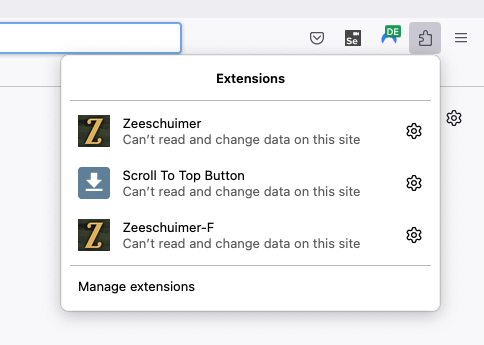
<figcaption aria-hidden="true">Screenshot of Firefox with open
extensions menu</figcaption>
</figure>

Fill in the *Firebase Project* field with the *project id* and
*aFirebase API Key* with the *api key* provided after running the
Project Creation. The *Firebase Endopint URL* will be provided via GRIPS
(unless you’ve installed your own instance).

<figure>
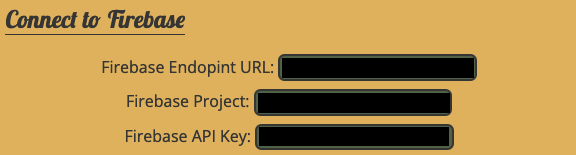
<figcaption aria-hidden="true">Screenshot of the Settings for
Zeeschuimer-F</figcaption>
</figure>

**1) Turn the *IG Stories* Switch on**, **2) restart your browser** for
the values to be loaded correctly. Once the browser has started again,
you’re ready to collect you first stories! Open the Instagram website
and open any story.

<figure>
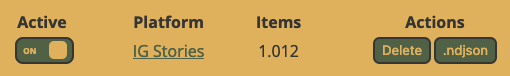
<figcaption aria-hidden="true">Screenshot of the switch</figcaption>
</figure>

Check the extension settings page to see whether it is collecting
stories while browsing. The counter should increase with each story
visit. The remote collection process can currently only be checked
through the Firebase Interface notebook. Follow the next steps to
download the collected data.

### Project Export

The following code downloads all stories in `JSON` format and saves it
locally (i.e. on your colab instance). Provide the `PROJECT_ID` variable
and an `export_path` to download all stories.

In [2]:
from tqdm.auto import tqdm
import os
import json

PROJECT_ID = '959466fe-4088-4099-a6b2-3cbe058889d3'
export_path = '/content/export' 


def fetch_stories(project_id):
    stories_ref = db.collection('projects').document(project_id).collection('stories')
    docs = stories_ref.stream()

    stories = []
    for doc in docs:
        stories.append(doc.to_dict())

    return stories

db = fetch_stories(PROJECT_ID)

if not os.path.exists('export'):
    os.makedirs('export')

# Iterate over each element in the database
for element in tqdm(db, desc='Exporting elements'):
    # Serialize the element to JSON
    element_json = json.dumps(element, indent=4)

    # Write to a file named {id}.json
    with open(os.path.join('export', f"{element['id']}.json"), 'w') as f:
        f.write(element_json)

### Convert to DataFrame

Next, we convert the exported `JSON` files to a `pandas` DataFrame and
save the table as `CSV`. Provide the `df_export_path` variable for the
location where to save the exported `CSV` file.

> **Work-In-Progress**
>
> The DataFrame in the current version has a different structure than
> the one [we created when downloading Instagram
> Posts.](../data-collection/ig-posts.qmd). In order to compare stories
> with posts we will might want to use the same data structure.

In [3]:

import pandas as pd
from datetime import datetime, timedelta


df_export_path = '/content/2022-11-09-Stories-Exported.csv' 

def process_instagram_story(data):

    # Extract relevant information
    story_info = {
        'ID': data.get("id"),
        'Time of Posting': datetime.utcfromtimestamp(data['taken_at']).strftime('%Y-%m-%d %H:%M:%S'),
        'Type of Content': 'Video' if 'video_duration' in data else 'Image',
        'video_url': None,
        'image_url': None,
        'Username': data['user']['username'],
        'Video Length (s)': data.get('video_duration', None),
        'Expiration': (datetime.utcfromtimestamp(data['taken_at']) + timedelta(hours=24)).strftime('%Y-%m-%d %H:%M:%S'),
        'Caption': data.get('caption', None),
        'Is Verified': data['user']['is_verified'],
        'Stickers': data.get('story_bloks_stickers', []),
        'Accessibility Caption': data.get('accessibility_caption', ''),
        'Attribution URL': data.get('attribution_content_url', '')
    }

    return story_info

rows = []
for element in db:
  rows.append(process_instagram_story(element))

df = pd.DataFrame(rows)
df.to_csv(df_export_path)
print(f"Successfully exported {len(df)} rows as CSV.")

Successfully exported 22 rows as CSV.

Now let’s take a look at the structure of the exported data:

In [6]:
df.head()

### Download Images and Videos

All videos and images for our Instagram stories have been downloaded by
our firebase backend. They are saved in a [Cloud
Bucket](https://cloud.google.com/storage/docs/creating-buckets?hl=de).
The following cell helps with these two steps:

1.  Create a signed link to each video and image
2.  Download each file and saves it in the following structure:
    `{media_export_path}/{image|video}/{username}/{ID.jpg|mp4}`. It is
    important to keep a unique identifier (here `ID`) to map metadata
    and images for future data analysis.

Please provide a `storage_bucket` and `media_export_path`.

In [10]:
storage_bucket = "XXXX.appspot.com"  
media_export_path =  '/content/media/'

from firebase_admin import storage
import os
import requests

bucket = storage.bucket(storage_bucket)

def generate_signed_url(username, content_id, file_type):
    if file_type not in ['images', 'videos']:
        raise ValueError("Invalid file type specified")

    ext = 'jpeg' if file_type == 'images' else 'mp4'
    blob_path = f"projects/{PROJECT_ID}/stories/{file_type}/{username}/{content_id}.{ext}"
    blob = bucket.blob(blob_path)
    # Set the expiration of the link. Here, it's set to 24 hours.
    return blob.generate_signed_url(expiration=timedelta(hours=24), method='GET')

# Create a function to be applied across DataFrame rows
def apply_generate_signed_url(row):
    image_url = generate_signed_url(row['Username'], row['ID'], 'images')
    video_url = generate_signed_url(row['Username'], row['ID'], 'videos') if row['Type of Content'] == 'Video' else pd.NA
    return pd.Series({'image_url': image_url, 'video_url': video_url})

# Apply the function along the axis=1 (row-wise)
df[['image_url', 'video_url']] = df.apply(apply_generate_signed_url, axis=1)

# Now, creating the lists for images and videos can be done more efficiently
data_images = df.loc[df['image_url'].notna(), ['ID', 'image_url', 'Username', 'Time of Posting']] \
               .rename(columns={'image_url': 'url', 'Time of Posting': 'datetime'}) \
               .to_dict('records')

data_videos = df.loc[df['video_url'].notna(), ['ID', 'video_url', 'Username', 'Time of Posting']] \
               .rename(columns={'video_url': 'url', 'Time of Posting': 'datetime'}) \
               .to_dict('records')


def create_directories(base_path, entries, subdir):
    usernames = set(entry['Username'] for entry in entries)
    for username in usernames:
        os.makedirs(os.path.join(base_path, subdir, username), exist_ok=True)

def download_file(entry, media_type, media_export_path, session):
    directory = os.path.join(media_export_path, media_type, entry['Username'])
    ext = 'jpg' if media_type == 'images' else 'mp4'
    filename = os.path.join(directory, f"{entry['ID']}.{ext}")

    with session.get(entry['url'], stream=True) as response:
        if response.status_code == 200:
            with open(filename, 'wb') as file:
                for chunk in response.iter_content(8192):
                    file.write(chunk)
        else:
            print(f"Failed to download {entry['url']}. Status code: {response.status_code}")

session = requests.Session()
# Pre-create directories
create_directories(media_export_path, data_images, 'images')
create_directories(media_export_path, data_videos, 'videos')

# Download images
for entry in tqdm(data_images, desc="Downloading Images", unit="file"):
    download_file(entry, 'images', media_export_path, session)

# Download videos
for entry in tqdm(data_videos, desc="Downloading Videos", unit="file"):
    download_file(entry, 'videos', media_export_path, session)

print("Download complete!")


Download complete!

### Prepare Downloadable ZIP

Run the following to ZIP all files. *Optionally* copy them to Google
Drive.

In [ ]:
!zip -r 2023-11-09-Story-Media-Export.zip media/*

In [ ]:
!cp 2023-11-09-Story-Media-Export.zip /content/drive/MyDrive/